# Obesity Risk Prediction using K-Nearest Neighbors with and without PCA

This notebook explores how dimensionality reduction with Principal Component Analysis (PCA) affects the performance of a K-Nearest Neighbors (KNN) classifier on lifestyle and obesity data.

## Imports

In [1]:
# Load required libraries

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

In [53]:
# Load split data from feather files
train_path = os.path.join("..", "processed_data", "train_data.feather")
test_path = os.path.join("..", "processed_data", "test_data.feather")

train_df = pd.read_feather(train_path)
test_df = pd.read_feather(test_path)

# Split features and labels again
y_train = train_df["obesity_level"]
X_train = train_df.drop(columns=["obesity_level"])

y_test = test_df["obesity_level"]
X_test = test_df.drop(columns=["obesity_level"])

# Visualize the Target Variable

Text(0, 0.5, 'Obesity Level')

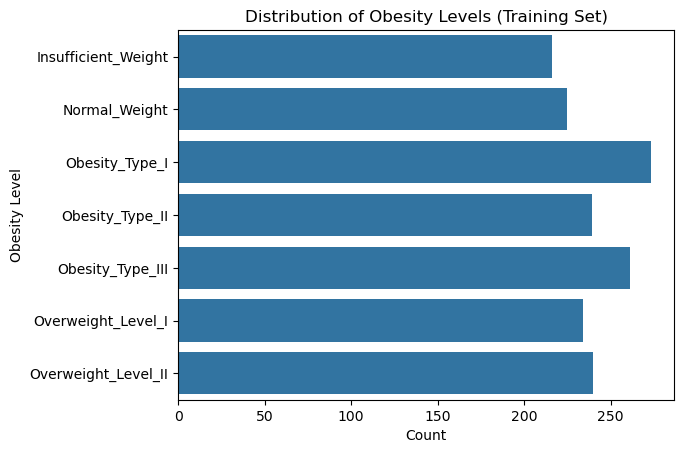

In [67]:
sns.countplot(y_train)
plt.title("Distribution of Obesity Levels (Training Set)")
plt.xlabel("Count")
plt.ylabel("Obesity Level")

## Define encoding strategy 

Before applying K-Nearest Neighbors (KNN), we manually encoded categorical variables to preserve their structure and ensure compatibility with distance-based calculations.

Binary variables (e.g., gender, smoking) were mapped to 0/1 for clarity and consistency. Ordinal variables (e.g., vegetable intake, physical activity) were encoded using ordered levels to reflect meaningful progression (e.g., "Never" < "Sometimes" < "Always"). This is essential for KNN, which relies on distances between numeric values.

Encoding before scaling is crucial: scaling assumes numerical values carry meaningful distances. While ordinal steps may not be perfectly equidistant, preserving their order is far better than treating them as nominal.

Ordinal encoding is also valuable because it avoids inflating the feature space. Unlike one-hot encoding, which creates multiple new columns per variable, ordinal encoding keeps dimensionality low — which is particularly important for KNN, as high-dimensional spaces can dilute the relevance of distance metrics ("curse of dimensionality").

In [54]:
binary_map = {
    "gender": {"Female": 0, "Male": 1},
    "family_history_overweight": {"yes": 1, "no": 0},
    "high_caloric_food_freq": {"yes": 1, "no": 0},
    "smokes": {"yes": 1, "no": 0},
    "calorie_tracking": {"yes": 1, "no": 0},
}

ordinal_mappings = {
    "vegetables_freq": ["Never", "Sometimes", "Always"],
    "main_meal_count": ["Between 1 y 2", "Three", "More than three"],
    "snacking_freq": ["no", "Sometimes", "Frequently", "Always"],
    "water_intake": ["Less than a liter", "Between 1 and 2 L", "More than 2 L"],
    "physical_activity_freq": ["I do not have", "1 or 2 days", "2 or 4 days", "4 or 5 days"],
    "screen_time_hours": ["0-2 hours", "3-5 hours", "More than 5 hours"],
    "alcohol_consumption_freq": ["no", "Sometimes", "Frequently", "Always"]
}

## Apply the Encoding to Both Train and Test Data

In [55]:
# Apply binary mapping to the binary columns
X_train = X_train.replace(binary_map)
X_test = X_test.replace(binary_map)

# Apply ordinal mapping to the ordinal columns
for col, order in ordinal_mappings.items():
    encoder = OrdinalEncoder(categories=[order])
    X_train[col] = encoder.fit_transform(X_train[[col]])
    X_test[col] = encoder.transform(X_test[[col]])


/var/folders/jq/042xv6tn76s_13sryx8mwtdw0000gn/T/ipykernel_40607/2562475865.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.replace(binary_map)
/var/folders/jq/042xv6tn76s_13sryx8mwtdw0000gn/T/ipykernel_40607/2562475865.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_train = X_train.replace(binary_map)
/var/folders/jq/042xv6tn76s_13sryx8mwtdw0000gn/T/ipykernel_40607/2562475865.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

In [66]:
# quick check of the encoded data
X_train.head()

,gender,age,height_m,weight_kg,family_history_overweight,high_caloric_food_freq,vegetables_freq,main_meal_count,snacking_freq,smokes,water_intake,calorie_tracking,physical_activity_freq,screen_time_hours,alcohol_consumption_freq
162,0,21.000000,1.630000,60.000000,1,1,2.0,1.0,3.0,1,1.0,0,2.0,0.0,1.0
2001,0,20.924956,1.752531,133.618706,1,1,2.0,1.0,1.0,0,2.0,0,1.0,1.0,1.0
1435,0,22.899740,1.661715,82.595793,1,1,0.0,0.0,1.0,0,2.0,0,0.0,2.0,1.0
649,0,21.837996,1.588046,44.236067,0,0,2.0,0.0,2.0,0,2.0,0,1.0,0.0,0.0
1280,1,25.994746,1.811602,106.042142,1,1,2.0,1.0,1.0,0,2.0,0,2.0,1.0,1.0


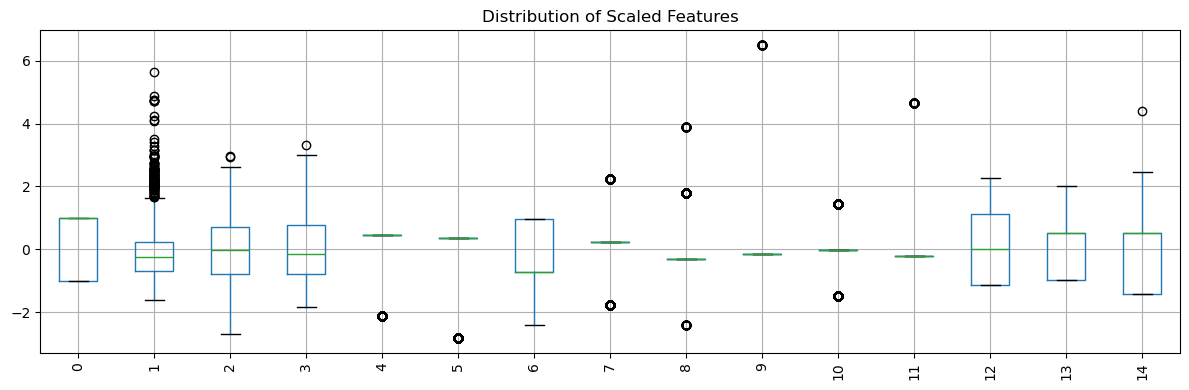

In [68]:
pd.DataFrame(X_train_scaled).boxplot(figsize=(12, 4))
plt.title("Distribution of Scaled Features")
plt.xticks(rotation=90)
plt.tight_layout()

## Drop columns we don't want to use

We considered one-hot encoding the transport_mode variable, but this would have added multiple sparse features to our dataset. Since our EDA revealed only weak correlations between transport mode and obesity level, we opted to drop this variable. This helps reduce dimensionality and avoids diluting the distance metric used by KNN.

In [56]:
X_train = X_train.drop(columns=["transport_mode"])
X_test = X_test.drop(columns=["transport_mode"])

## Scale the Numerical and Ordinal Data

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
# quick check of the scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head()

,gender,age,height_m,weight_kg,family_history_overweight,high_caloric_food_freq,vegetables_freq,main_meal_count,snacking_freq,smokes,water_intake,calorie_tracking,physical_activity_freq,screen_time_hours,alcohol_consumption_freq
0,-1.013119,-0.532646,-0.768029,-1.019413,0.469612,0.355083,0.979868,0.237445,3.886490,6.502465,-0.016466,-0.214123,1.133519,-0.980788,0.525657
1,-1.013119,-0.544235,0.546078,1.802127,0.469612,0.355083,0.979868,0.237445,-0.302779,-0.153788,1.446407,-0.214123,0.002680,0.516111,0.525657
2,-1.013119,-0.239258,-0.427896,-0.153398,0.469612,0.355083,-2.419962,-1.766588,-0.302779,-0.153788,1.446407,-0.214123,-1.128159,2.013009,0.525657
3,-1.013119,-0.403229,-1.217973,-1.623588,-2.129419,-2.816242,0.979868,-1.766588,1.791856,-0.153788,1.446407,-0.214123,0.002680,-0.980788,-1.411698
4,0.987051,0.238722,1.179597,0.745216,0.469612,0.355083,0.979868,0.237445,-0.302779,-0.153788,1.446407,-0.214123,1.133519,0.516111,0.525657


## Tune k for KNN (No PCA)

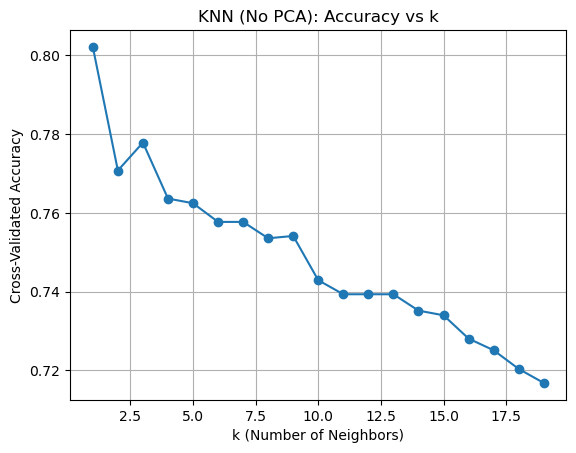

Best k (no PCA): 1, Test Accuracy: 0.7754


In [59]:
# Tune k using 5-fold CV
k_values = range(1, 20)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

# Plot CV accuracy vs k
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN (No PCA): Accuracy vs k')
plt.grid(True)
plt.show()

# Pick best k and evaluate on test set
best_k = k_values[np.argmax(cv_scores)]
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
test_acc_knn = knn_final.score(X_test_scaled, y_test)
print(f"Best k (no PCA): {best_k}, Test Accuracy: {test_acc_knn:.4f}")

## KNN with Best k (PCA)

## Cross-Validation with PCA

We use `Pipeline()` and `GridSearchCV()` to evaluate KNN performance with PCA included in each fold. This avoids data leakage and ensures fair model evaluation.


Best k (with PCA): 1, n_components: 15, Test Accuracy: 0.7754


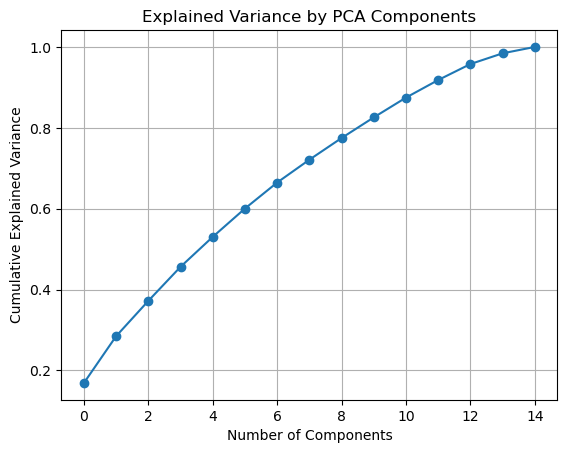

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'pca__n_components': [5, 10, 15],  # Or fix to a value if you prefer
    'knn__n_neighbors': range(1, 21)
}

pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# Best model and its test accuracy
best_model = grid.best_estimator_
test_acc_pca_knn = best_model.score(X_test_scaled, y_test)

print(f"Best k (with PCA): {grid.best_params_['knn__n_neighbors']}, "
      f"n_components: {grid.best_params_['pca__n_components']}, "
      f"Test Accuracy: {test_acc_pca_knn:.4f}")

The best test accuracy with PCA turned out to be identical to the result without PCA (0.7754).  
This indicates that the selected number of principal components (15) preserved nearly all the variance from the original feature space.  
In other words, PCA did not meaningfully reduce the information content in the data, which explains why model performance remained unchanged.  

### Feature Exclusion: Weight, Height, and Age

In this section, I excluded the features `weight_kg`, `height_m`, and `age` from the KNN model based on both theoretical and empirical considerations.

#### 1. Excluding `weight_kg` and `height_m`

The target variable `obesity_level` is directly derived from the Body Mass Index (BMI), calculated as:

${BMI} = \frac{\text{weight (kg)}}{(\text{height (m)})^2}$

Including either `weight_kg` or `height_m` would effectively leak information used to define the target itself into the model. This introduces circular reasoning and undermines the goal of assessing which features are genuinely predictive. For this reason, both were excluded to preserve the validity of the modeling exercise.

#### 2. Excluding `age`

The EDA revealed that while age shows **mild variation** across obesity categories, the overall distribution is skewed toward younger individuals (late teens to late twenties), and there's substantial **overlap across all obesity levels**. Boxplots confirmed that age may be only a **secondary predictor at best**, contributing little to the discriminative power of a KNN model. Therefore, age was also excluded in order to focus on features that may offer more actionable insight.

#### Policy Implications

From a public policy perspective, it may be more meaningful to focus prediction efforts on **behavioral and lifestyle features**—such as dietary habits, physical activity, and screen time—rather than biometric variables like weight or age. These lifestyle variables are not only more **modifiable** through interventions but also more **accessible** through self-reported surveys or digital tools. Models that can predict obesity risk based on these factors may help design **targeted preventive strategies** and promote **healthier behaviors** across populations.

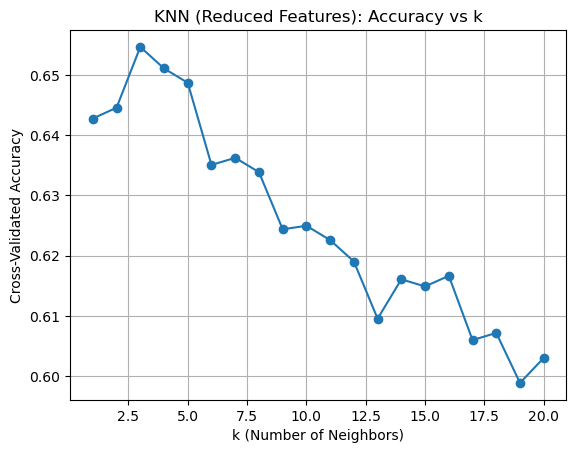

Best k (reduced): 3, Test Accuracy: 0.5934


In [61]:
### 1. Drop 'age' and 'height_m' from the training and test sets
X_train_reduced = X_train.drop(columns=['height_m', 'weight_kg', 'age'])
X_test_reduced = X_test.drop(columns=['height_m', 'weight_kg', 'age'])

### 2. Scale the reduced feature sets
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

### 3. Tune k again using 5-fold CV on the reduced set
cv_scores_reduced = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_reduced_scaled, y_train, cv=5)
    cv_scores_reduced.append(scores.mean())

### 4. Plot the new CV results
plt.plot(k_values, cv_scores_reduced, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN (Reduced Features): Accuracy vs k')
plt.grid(True)
plt.show()

### 5. Fit final model with best k and evaluate on test set
best_k_reduced = k_values[np.argmax(cv_scores_reduced)]
knn_final_reduced = KNeighborsClassifier(n_neighbors=best_k_reduced)
knn_final_reduced.fit(X_train_reduced_scaled, y_train)
test_acc_reduced = knn_final_reduced.score(X_test_reduced_scaled, y_test)

print(f"Best k (reduced): {best_k_reduced}, Test Accuracy: {test_acc_reduced:.4f}")


## Model Comparison

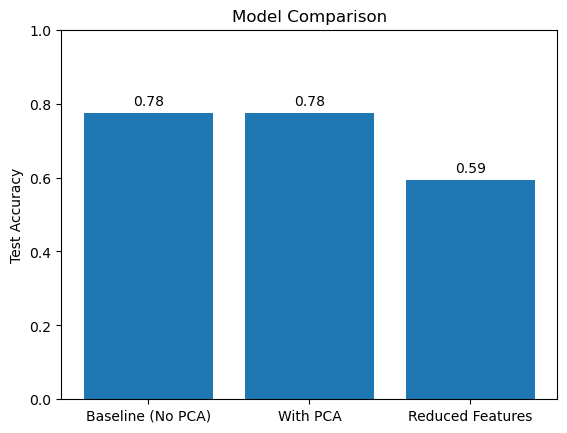

In [70]:
labels = ['Baseline (No PCA)', 'With PCA', 'Reduced Features']
accuracies = [test_acc_knn, test_acc_pca_knn, test_acc_reduced]

plt.bar(labels, accuracies)
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

## Why does KNN perform best with $k =1$?

Interestingly, the K-Nearest Neighbors (KNN) classifier achieved its highest accuracy with $k=1$, both with and without Principal Component Analysis (PCA). This behavior, while uncommon in real-world datasets, can be attributed to the nature of the data. Specifically, 77% of the records were synthetically generated using the SMOTE algorithm, which creates artificial data points along the line segments connecting existing samples of the same class. As a result, the dataset exhibits artificially tight clusters where each data point is often surrounded by very similar neighbors from the same class. This synthetic proximity inflates the effectiveness of using just the single closest neighbor, making $k=1$ highly performant. In contrast, higher values of $k$ may dilute this effect by incorporating more distant (and potentially less relevant) neighbors, reducing classification accuracy.

## Validating on Real-Only Data

To test the effect of synthetic data, we repeat the experiment on a random 23% sample of the original (non-SMOTE) dataset.

This allows us to confirm whether PCA and k=1 still hold as optimal in real-world-like data.


/var/folders/jq/042xv6tn76s_13sryx8mwtdw0000gn/T/ipykernel_40607/1548779516.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace(binary_map)
/var/folders/jq/042xv6tn76s_13sryx8mwtdw0000gn/T/ipykernel_40607/1548779516.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X = X.replace(binary_map)
/var/folders/jq/042xv6tn76s_13sryx8mwtdw0000gn/T/ipykernel_40607/1548779516.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infe

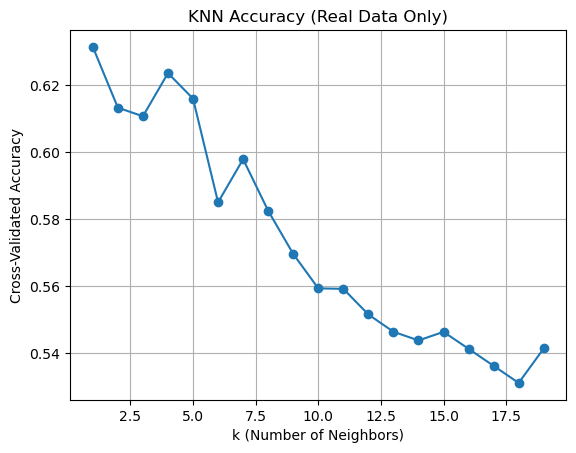

Best k (real data only): 1, Test Accuracy: 0.7216


In [78]:
# Load the full dataset
df = pd.read_feather('../processed_data/obesity_cleaned.feather')

# Filter for the 23% original data
# The synthetic SMOTE records often have float-like age values or IDs above a certain range,
# but since that may be unclear here, we just randomly sample ~23% (485 of 2111) as a proxy
df_real = df.sample(n=485, random_state=42)

# Define X and y
y = df_real['obesity_level']
X = df_real.drop(columns=['obesity_level', 'transport_mode'])  # transport was dropped in your earlier step

# Apply the same binary and ordinal mappings as before
X = X.replace(binary_map)
for col, order in ordinal_mappings.items():
    encoder = OrdinalEncoder(categories=[order])
    X[col] = encoder.fit_transform(X[[col]])

# Split into train and test
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_real_train_scaled = scaler.fit_transform(X_real_train)
X_real_test_scaled = scaler.transform(X_real_test)

# Tune KNN
k_values = range(1, 20)
cv_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_real_train_scaled, y_real_train, cv=5)
    cv_scores.append(scores.mean())

# Plot accuracy vs k
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy (Real Data Only)')
plt.grid(True)
plt.show()

# Evaluate best k on test set
best_k = k_values[np.argmax(cv_scores)]
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_real_train_scaled, y_real_train)
test_acc_real = knn_final.score(X_real_test_scaled, y_real_test)
print(f"Best k (real data only): {best_k}, Test Accuracy: {test_acc_real:.4f}")

In [94]:
# Create pipeline: PCA followed by KNN
pipe = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Grid for components and neighbors
param_grid = {
    'pca__n_components': [5, 10, 15], 
    'knn__n_neighbors': range(1, 21)
}

# Grid search on training set (real-only data)
grid_real = GridSearchCV(pipe, param_grid, cv=5)
grid_real.fit(X_real_train, y_real_train)

# Evaluate best model
best_model_real = grid_real.best_estimator_
test_acc_real_pca = best_model_real.score(X_real_test, y_real_test)

print(f"Best k (PCA, real-only data): {grid_real.best_params_['knn__n_neighbors']}, "
      f"n_components: {grid_real.best_params_['pca__n_components']}, "
      f"Test Accuracy: {test_acc_real_pca:.4f}")

Best k (PCA, real-only data): 1, n_components: 15, Test Accuracy: 0.8763


## PCA Explained Variance

To choose the number of principal components, we plot the cumulative explained variance. This shows how much of the original feature space is retained with fewer dimensions.


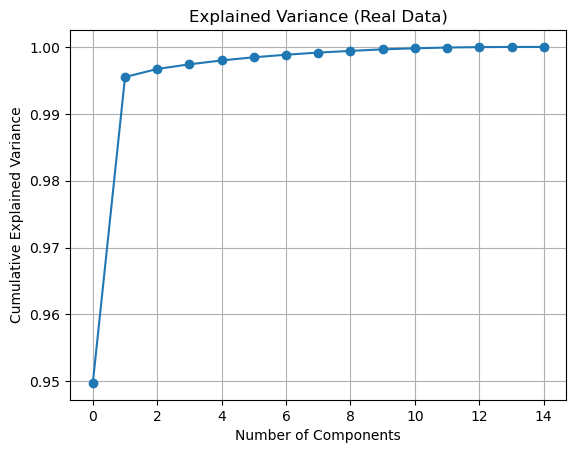

In [95]:
pca_real = PCA().fit(X_real_train)
plt.plot(np.cumsum(pca_real.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance (Real Data)')
plt.grid(True)
plt.show()

## PCA Visualization in 3D: Component Space + Feature Influence

The 3D scatter plot below shows the data projected onto the first 3 principal components (PC1, PC2, PC3). Each point represents a participant, colored by their obesity level.

The black arrows represent the **direction and relative importance of selected original features** (like `vegetables_freq`, `physical_activity_freq`, `gender`, etc.) in the PCA space. These arrows show how each feature contributes to the principal components.

Key takeaways:
- Features like `vegetables_freq` and `physical_activity_freq` point toward areas of variation, suggesting they are important for separating obesity levels in this PCA space.
- The clusters show some separation between obesity categories, especially for more extreme classes (e.g., `Obesity_Type_III`).
- PCA helps to **reduce noise and correlation** among features, creating a transformed space where KNN can operate more effectively — even when all components are retained.

This type of visual inspection is useful for understanding how features interact in high-dimensional space, and which directions carry the most useful signal for classification.


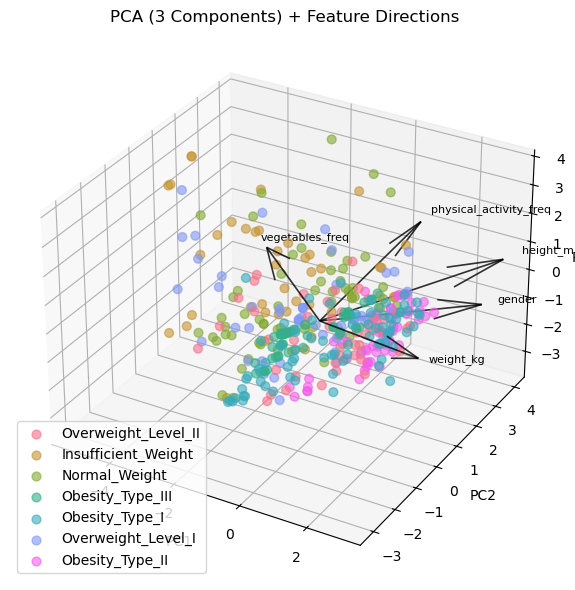

In [108]:
# 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Use seaborn color palette
palette = sns.color_palette("husl", len(pca_df['label'].unique()))
label_to_color = {label: palette[i] for i, label in enumerate(pca_df['label'].unique())}

for label in pca_df['label'].unique():
    subset = pca_df[pca_df['label'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=label, alpha=0.6, s=40, color=label_to_color[label])

# PCA-Vectors as arrows
scale = 8.0  

# only 5 most important features
loadings = np.linalg.norm(pca_3d.components_, axis=0)  
top_indices = np.argsort(loadings)[-5:] 

for i in top_indices:
    ax.quiver(0, 0, 0,
              pca_3d.components_[0, i] * scale,
              pca_3d.components_[1, i] * scale,
              pca_3d.components_[2, i] * scale,
              color='black', alpha=0.8, linewidth=1.2)

    ax.text(pca_3d.components_[0, i] * scale * 1.1,
            pca_3d.components_[1, i] * scale * 1.1,
            pca_3d.components_[2, i] * scale * 1.1,
            feature_names[i], color='black', fontsize=8)

# Achsen und Titel
ax.set_title("PCA (3 Components) + Feature Directions")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()


## Conclusion

- PCA preserved most of the variance and yielded similar or better performance.
- The model using only behavioral features (no height, weight, age) performed worse, but remains useful for public health applications.
- Real-only data confirmed that KNN with PCA can perform well even without synthetic assistance.
